In [1]:
%matplotlib inline  

from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from barcode import Barcode
from barcode_simulator import BarcodeSimulator
from all_reads import CellReads, CellRead
from cell_state import CellTypeTree, CellState
from cell_state_simulator import CellTypeSimulator
from clt_simulator import CLTSimulator
from clt_observer import CLTObserver
from constants import BARCODE_V7, NUM_BARCODE_V7_TARGETS

/Users/jeanfeng/anaconda_ete/envs/anaconda_venv/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/jeanfeng/anaconda_ete/envs/anaconda_venv/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [163]:
START_BASE = 120
BARCODE_SPACER_LEN = 27
TARGET_LEN = 23

birth_lambda = 1.2
death_lambda = 0.01

target_lambdas = [0.3 for _ in range(10)]
repair_lambdas = [1, 2]
repair_indel_probability = 0.5
repair_deletion_lambda = 8
repair_insertion_lambda = 0.5

time = 10

sampling_rate = 0.1

In [164]:
cell_types = ["brain", "eye"]
cell_type_tree = CellTypeTree(cell_type=None, rate=0)
cell_type_tree.add_child(
    CellTypeTree(cell_type=0, rate=0.05))
cell_type_tree.add_child(
    CellTypeTree(cell_type=1, rate=0.05))

Tree node '' (0x1d3cf147)

In [165]:
bcode_simulator = BarcodeSimulator(
        np.array(target_lambdas),
        np.array(repair_lambdas), repair_indel_probability,
        repair_deletion_lambda, repair_deletion_lambda,
        repair_insertion_lambda)
cell_type_simulator = CellTypeSimulator(cell_type_tree)
clt_simulator = CLTSimulator(
    birth_lambda,
    death_lambda,
    cell_type_simulator,
    bcode_simulator)

In [166]:
clt = clt_simulator.simulate(Barcode(), CellState(categorical=cell_type_tree), time)

In [167]:
observer = CLTObserver(sampling_rate)
obs_leaves = observer.observe_leaves(clt, give_pruned_clt=False)

all_reads = [CellRead(obs.barcode.get_event_encoding(), obs.cell_state.categorical_state) for obs in obs_leaves]
print(len(all_reads))
cell_type_dict = {"0": cell_types[0], "1": cell_types[1], "0,1": "0,1"}
cell_reads = CellReads(all_reads, cell_type_dict)

998


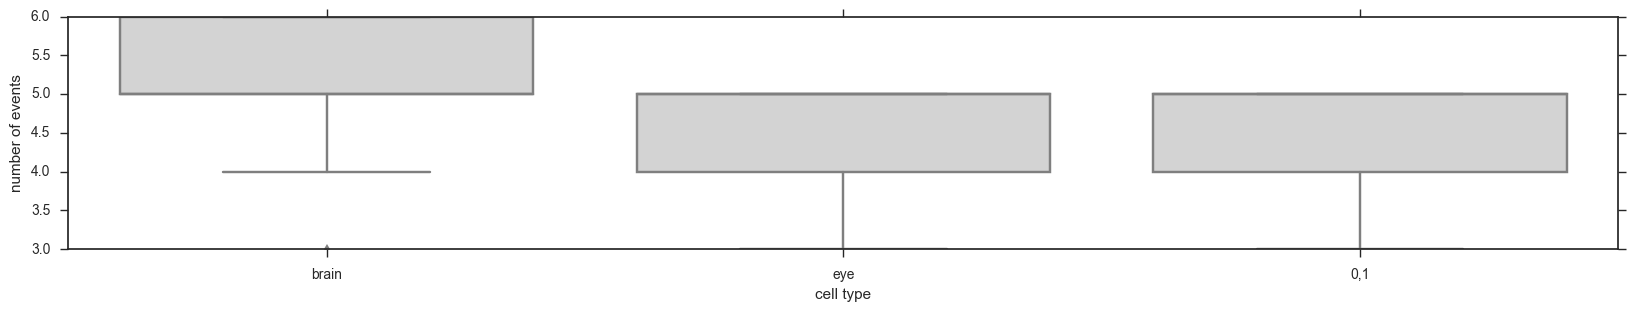

In [168]:
"""
distributions of the number of (visible) events in each cell type
"""
df = pd.DataFrame([(cell_reads.organ_dict[x.organ.get_gen_name()], len(x.events)) for x in cell_reads.reads],
                  columns=('cell type', 'number of events'))
plt.figure(figsize=(20, 3))
sns.boxplot(x='cell type', y='number of events', data=df, color='lightgrey')

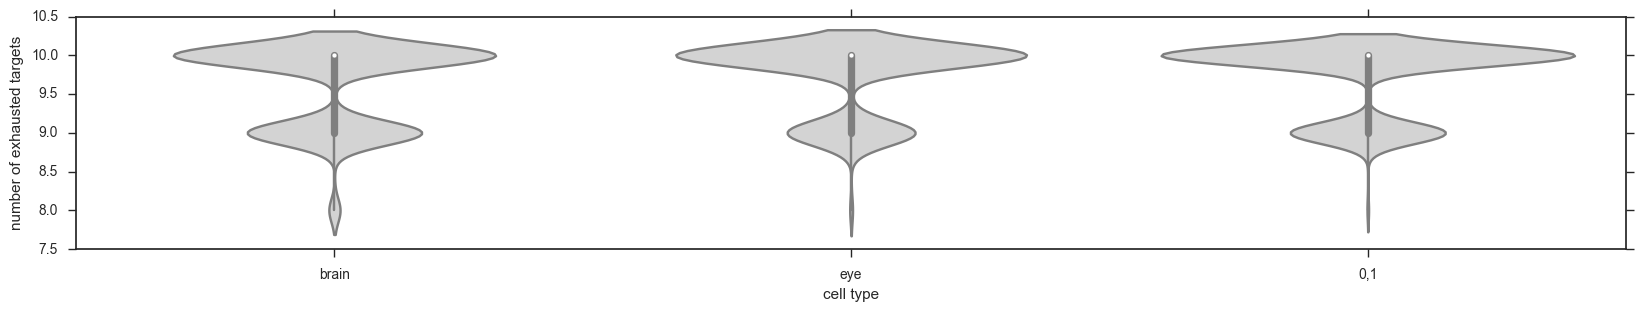

In [169]:
"""
distributions of the number of exhausted targets in each cell type
"""
df = pd.DataFrame([(cell_reads.organ_dict[x.organ.get_gen_name()], len(x.barcode.get_used_targets())) for x in cell_reads.reads],
                  columns=('cell type', 'number of exhausted targets'))
plt.figure(figsize=(20, 3))
sns.violinplot(x='cell type', y='number of exhausted targets', data=df, color='lightgrey')

In [170]:
"""
Really basic data characteristics
"""
num_cells = len(cell_reads.reads)
print("# of cells:", num_cells)
print("# of unique barcodes (alleles):", len(cell_reads.uniq_barcodes))

# of cells: 998
# of unique barcodes (alleles): 998


In [171]:
"""
Organ data distribution
"""
organ_barcode_dict = dict()
for b in cell_reads.reads:
    organ= cell_reads.organ_dict[b.organ.get_gen_name()]
    if organ not in organ_barcode_dict:
        organ_barcode_dict[organ] = []
    organ_barcode_dict[organ].append(b)
    
for organ, barcodes in organ_barcode_dict.items():
    bcode_strs = [".".join([str(evt) for evt in b.events]) for b in barcodes]
    uniq_bcodes = set(bcode_strs)
    num_organ_cells = len(barcodes)
    print("# of %s cells: %d (%f%%)" % (organ, num_organ_cells, (100 * num_organ_cells)/num_cells))
    print("  # of unique barcodes:", len(uniq_bcodes))
        

# of 0,1 cells: 371 (37.174349%)
  # of unique barcodes: 371
# of brain cells: 454 (45.490982%)
  # of unique barcodes: 454
# of eye cells: 173 (17.334669%)
  # of unique barcodes: 173


In [172]:
# Process unique insertions
uniq_inserts = set()
uniq_insert_strs = set()
for b in cell_reads.uniq_barcodes:
    for evt in b.events:
        if evt.del_len == 0:
            if str(evt) in uniq_insert_strs:
                continue
            else:
                uniq_insert_strs.add(str(evt))
                uniq_inserts.add(evt)

In [173]:
# Process insertions with target idx
all_insert_target_pos = []
for b in cell_reads.uniq_barcodes:
    for evt in b.events:
        if evt.del_len == 0:
            all_insert_target_pos.append((evt.min_target, evt))

In [174]:
"""
Interpretation: There aren't that many insertion locations possible
"""
num_insert_evt = np.sum([evt.del_len == 0 for evt in cell_reads.uniq_events])
print("# unique insertion events:", num_insert_evt)
insert_pos = [ins.start_pos for ins in uniq_inserts]
num_uniq_insert_start = np.unique(insert_pos).size
print("# unique insertion positions:", num_uniq_insert_start)

# unique insertion events: 24
# unique insertion positions: 4


In [175]:
"""
A summary table of the length of unique insertion events

Interpretation: There is actually a wide range of insertion lengths (up to 48 bp!).
Most insertions are short. However some insertion lengths seem to be more favorable.
Even though we only look at unique insertions, there are a large number of
unique insertions that are all length 12, 15, 20, and 23.
"""
insert_len = [ins.insert_len for ins in uniq_inserts]
Counter(insert_len)

Counter({1: 11, 2: 11, 3: 2})

In [176]:
"""
Where are things inserted for each target, what is the usual position, what is the usual length?
The numbers below are median (min, max)
"""
insert_target_summary = [
    {'count': 0, 'locations': [], 'lengths': [], 'uniq_strs': set()} for i in range(NUM_BARCODE_V7_TARGETS)
]
for target_i, evt in all_insert_target_pos:
    if str(evt) in insert_target_summary[target_i]['uniq_strs']:
        continue
    else:
        insert_target_summary[target_i]['uniq_strs'].add(str(evt))
        insert_target_summary[target_i]["count"] += 1
        insert_target_summary[target_i]["locations"].append(evt.start_pos)
        insert_target_summary[target_i]["lengths"].append(evt.insert_len)

for target_i, target_dict in enumerate(insert_target_summary):
    print("Target", target_i)
    print("  Count:", target_dict['count'])
    if target_dict['count'] > 0:
        locs = target_dict['locations']
        print("  Location:", np.median(locs), "(", np.min(locs), ",", np.max(locs), ")")
        lens = target_dict['lengths']
        print("  Lengths:", np.median(lens), "(", np.min(lens), ",", np.max(lens), ")")

Target 0
  Count: 1
  Location: 19.0 ( 19 , 19 )
  Lengths: 1.0 ( 1 , 1 )
Target 1
  Count: 4
  Location: 46.0 ( 46 , 46 )
  Lengths: 1.5 ( 1 , 2 )
Target 2
  Count: 12
  Location: 73.0 ( 73 , 73 )
  Lengths: 2.0 ( 1 , 3 )
Target 3
  Count: 7
  Location: 100.0 ( 100 , 100 )
  Lengths: 1.0 ( 1 , 3 )
Target 4
  Count: 0
Target 5
  Count: 0
Target 6
  Count: 0
Target 7
  Count: 0
Target 8
  Count: 0
Target 9
  Count: 0


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   7.]),
 array([  19.  ,   20.62,   22.24,   23.86,   25.48,   27.1 ,   28.72,
          30.34,   31.96,   33.58,   35.2 ,   36.82,   38.44,   40.06,
          41.68,   43.3 ,   44.92,   46.54,   48.16,   49.78,   51.4 ,
          53.02,   54.64,   56.26,   57.88,   59.5 ,   61.12,   62.74,
          64.36,   65.98,   67.6 ,   69.22,   70.84,   72.46,   74.08,
          75.7 ,   77.32,   78.94,   80.56,   82.18,   83.8 ,   85.42,
          87.04,   88.66,   90.28,   91.9 ,   93.52,   95.14,   96.76,
          98.38,  100.  ]),
 <a list of 50 Patch objects>)

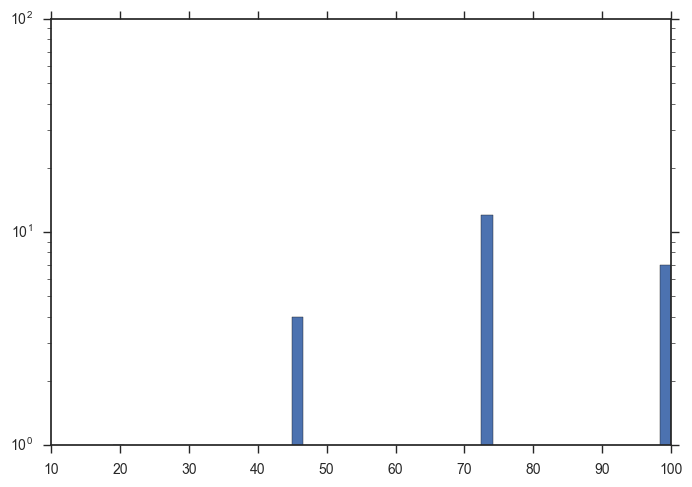

In [177]:
"""
Plot: histogram of insertion positions
"""
plt.hist(insert_pos, bins=50, log=True)

In [178]:
# Process unique deletions
uniq_deletes = set()
for b in cell_reads.uniq_barcodes:
    for evt in b.events:
        if evt.del_len > 0:
            if evt in uniq_deletes:
                continue
            else:
                uniq_deletes.add(evt)

# Process deletions with target idx
all_delete_target_pos = []
for b in cell_reads.uniq_barcodes:
    for evt in b.events:
        if evt.del_len > 0:
            all_delete_target_pos.append((evt.min_target, evt))

In [179]:
"""
Counting deletion events and positions

Interpretation: There are quite a lot of deletion positions possible. The total barcode is only 270 long.
We are starting deletes from almost every position.
"""
num_delete_evt = np.sum([evt.del_len == 0 for evt in cell_reads.uniq_events])
print("# unique delete events:", num_delete_evt)
delete_pos = [deletion.start_pos for deletion in uniq_deletes]
num_uniq_delete_start = np.unique(delete_pos).size
print("# unique deletion start positions:", num_uniq_delete_start)
delete_end_pos = [deletion.start_pos + deletion.del_len - 1 for deletion in uniq_deletes]
num_uniq_delete_end = np.unique(delete_end_pos).size
print("# unique deletion end positions:", num_uniq_delete_end)

# unique delete events: 24
# unique deletion start positions: 63
# unique deletion end positions: 59


(array([  40.,   92.,   98.,  107.,   59.,   26.,   11.,    5.,    3.,
           8.,   12.,    1.,    2.,    0.,    0.,    0.,    2.,    0.,
           0.,    1.]),
 array([  2.  ,   5.65,   9.3 ,  12.95,  16.6 ,  20.25,  23.9 ,  27.55,
         31.2 ,  34.85,  38.5 ,  42.15,  45.8 ,  49.45,  53.1 ,  56.75,
         60.4 ,  64.05,  67.7 ,  71.35,  75.  ]),
 <a list of 20 Patch objects>)

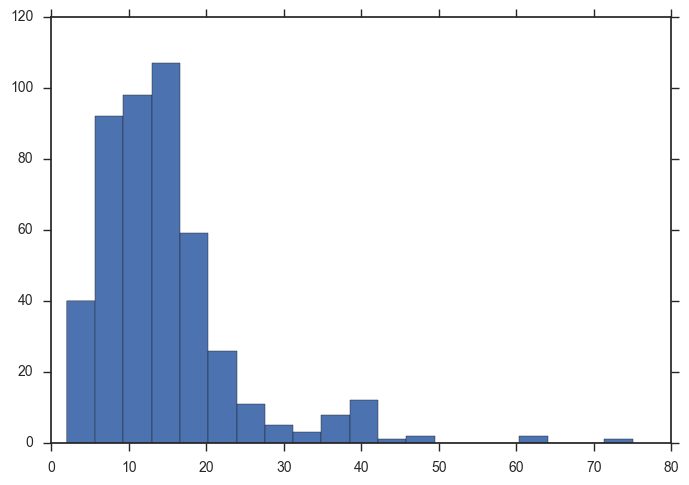

In [180]:
"""
Histogram of the lengths of deletions
"""
# A summary table of the length of unique deletion events
del_len = [ins.del_len for ins in uniq_deletes]
plt.hist(del_len, bins=20)

(array([  3.,   2.,   4.,  13.,   8.,   6.,   3.,  10.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   8.,   8.,   8.,   2.,   4.,   0.,
         16.,   0.,   0.,   1.,   0.,   3.,  11.,   5.,  24.,  33.,  35.,
         33.,  18.,   5.,  56.,   0.,   0.,   0.,   1.,   0.,   2.,   5.,
         15.,  25.,  27.,  24.,   9.,   2.,  34.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   4. ,    5.9,    7.8,    9.7,   11.6,   13.5,   15.4,   17.3,
          19.2,   21.1,   23. ,   24.9,   26.8,   28.7,   30.6,   32.5,
          34.4,   36.3,   38.2,   40.1,   42. ,   43.9,   45.8,   47.7,
          49.6,   51.5,   53.4,   55.3,   57.2,   59.1,   61. ,   62.9,
          64.8,   66.7,   68.6

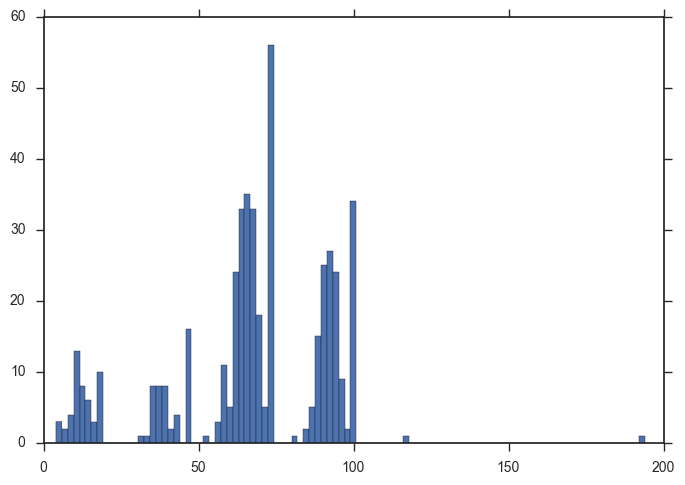

In [181]:
"""
Plot: histogram of deletion start locations

Picture: deletion start locations for each unique deletion event.
You can spot 10 peaks, but it's a bit difficult. Deleions can start anywhere!
"""
plt.hist(delete_pos, bins=100)

(array([ 10.,   3.,  10.,   8.,   9.,   2.,   1.,   0.,   0.,   0.,  12.,
          0.,   8.,   8.,  13.,   6.,   2.,   0.,   0.,   0.,   0.,  42.,
         13.,  26.,  56.,  29.,  32.,   6.,   2.,   0.,   0.,   0.,  46.,
          7.,  34.,  31.,  28.,  12.,   9.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  18. ,   20.5,   23. ,   25.5,   28. ,   30.5,   33. ,   35.5,
          38. ,   40.5,   43. ,   45.5,   48. ,   50.5,   53. ,   55.5,
          58. ,   60.5,   63. ,   65.5,   68. ,   70.5,   73. ,   75.5,
          78. ,   80.5,   83. ,   85.5,   88. ,   90.5,   93. ,   95.5,
          98. ,  100.5,  103. 

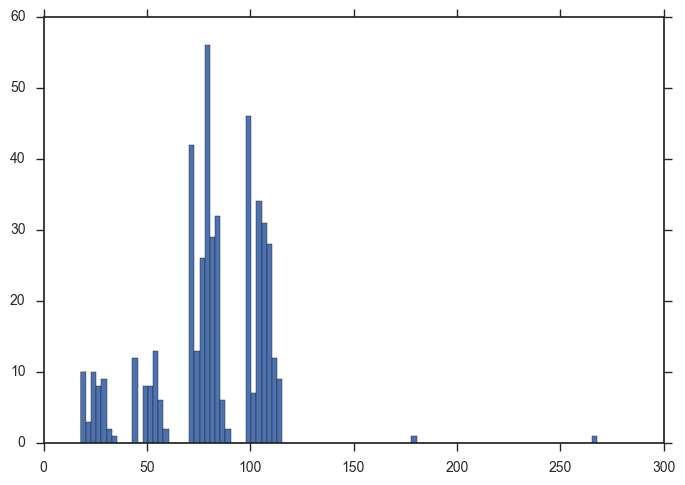

In [182]:
"""
Plot: histogram of deletion end locations
"""
plt.hist(delete_end_pos, bins=100)

In [159]:
"""
Where are things deleted for each target, what is the usual position, what is the usual length?
The numbers below are median (min, max)

Interpretation: The median position for the deletion for each target is pretty evenly spaced.
Median deletion length is actually quite high!
"""
del_target_summary = [
    {'count': 0, 'locations': [], 'lengths': [], 'uniq_evts': set()}
    for i in range(NUM_BARCODE_V7_TARGETS)
]
for target_i, evt in all_delete_target_pos:
    del_target_summary[target_i]['uniq_evts'].add(evt)
    del_target_summary[target_i]["count"] += 1
    del_target_summary[target_i]["locations"].append(evt.start_pos)
    del_target_summary[target_i]["lengths"].append(evt.del_len)

for target_i, target_dict in enumerate(del_target_summary):
    print("Target", target_i)
    print("  Count:", target_dict['count'])
    if target_dict['count'] > 0:
        locs = target_dict['locations']
        print("  Location:", np.median(locs), "(", np.min(locs), ",", np.max(locs), ")")
        lens = target_dict['lengths']
        print("  Lengths:", np.median(lens), "(", np.min(lens), ",", np.max(lens), ")")

Target 0
  Count: 111
  Location: 17.0 ( 11 , 19 )
  Lengths: 197.0 ( 5 , 201 )
Target 1
  Count: 10
  Location: 39.0 ( 39 , 46 )
  Lengths: 91.0 ( 8 , 169 )
Target 2
  Count: 5
  Location: 68.0 ( 68 , 68 )
  Lengths: 5.0 ( 5 , 5 )
Target 3
  Count: 5
  Location: 96.0 ( 96 , 96 )
  Lengths: 85.0 ( 85 , 85 )
Target 4
  Count: 0
Target 5
  Count: 0
Target 6
  Count: 0
Target 7
  Count: 3
  Location: 208.0 ( 202 , 208 )
  Lengths: 9.0 ( 5 , 14 )
Target 8
  Count: 83
  Location: 229.0 ( 221 , 235 )
  Lengths: 9.0 ( 1 , 41 )
Target 9
  Count: 77
  Location: 256.0 ( 250 , 262 )
  Lengths: 8.0 ( 2 , 17 )


Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9


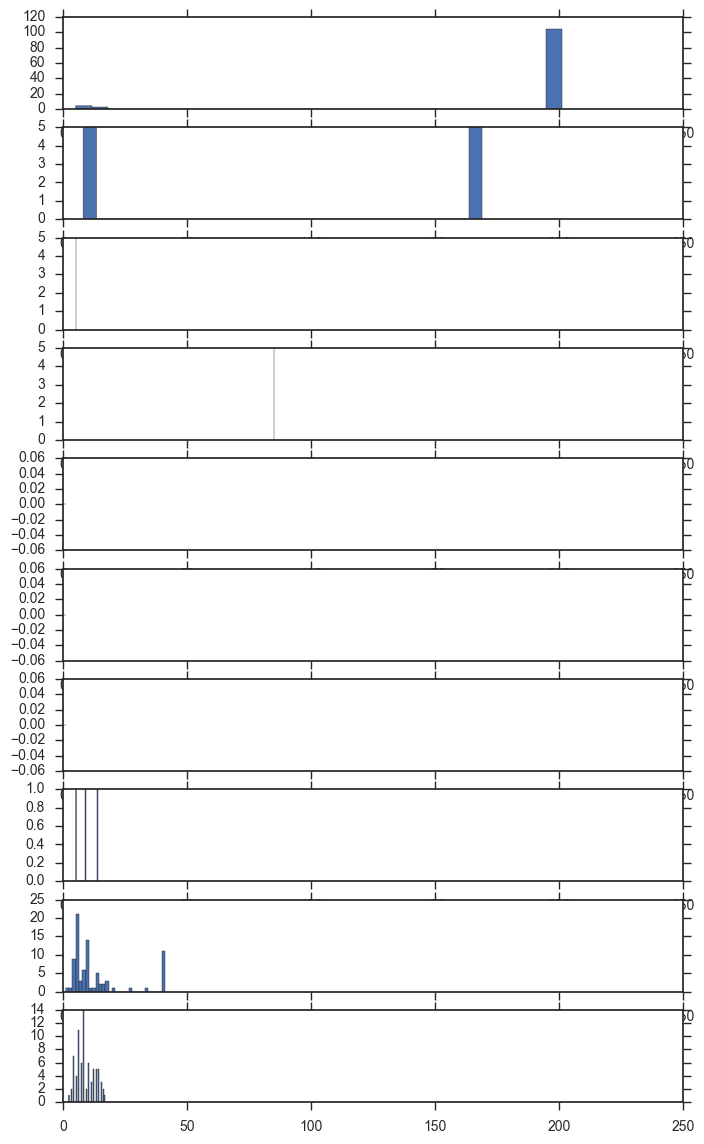

In [183]:
"""
Plot: deletion length histogram for deletion events that start at this target.

Interpretation: The deletion length profiles vary across the targets.
The deletion lengths can vary widely, some going up to 200+ bp.
Shorter deletions are preferred.
"""
plt.figure(figsize=(8,14))
for target_i, target_dict in enumerate(del_target_summary):
    print("Target", target_i)
    plt.subplot(NUM_BARCODE_V7_TARGETS, 1, target_i + 1, xlim = [0, 250])
    plt.hist(target_dict['lengths'], bins=30)

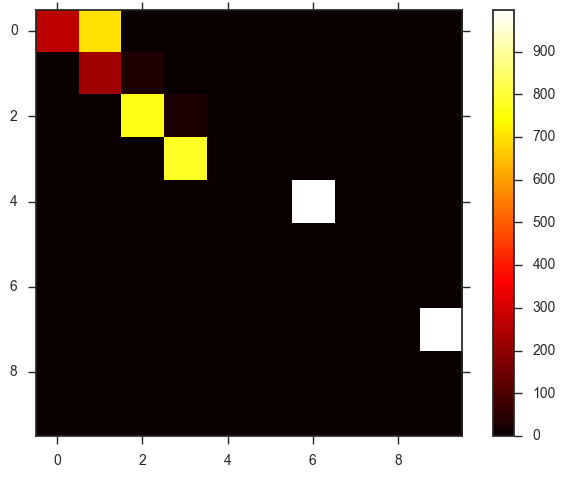

In [184]:
"""
How often do intertarget deletions occur?
e.g. do targets 0 and 9 often get cut together?

Interpretation: most deletions are in the same target. The next most common deletions occur across two targets.
There are very few very long inter-target deletions.
"""
uniq_deletion_strs = set()
intertarget_pairs = np.zeros((NUM_BARCODE_V7_TARGETS, NUM_BARCODE_V7_TARGETS))
for b in cell_reads.uniq_barcodes:
    for evt in b.events:
        if evt.del_len > 0:
            uniq_deletion_strs.add(evt)
            intertarget_pairs[evt.min_target, evt.max_target] += 1
plt.imshow(intertarget_pairs, cmap='hot', interpolation='nearest')
plt.colorbar()

In [185]:
"""
Average number of targets disturbed for each barcode

Interpretation: Most barcodes have most targets modified by the time we sequence.
This is like how the paper mentioned that we have saturated the barcodes.
"""
all_num_disturbed = []
for b in cell_reads.uniq_barcodes:
    disturbed_targs = [0 for i in range(10)]
    for evt in b.events:
        for targ in range(evt.min_target, evt.max_target + 1):
            disturbed_targs[targ] = 1
    num_disturbed = sum(disturbed_targs)
    all_num_disturbed.append(num_disturbed)
Counter(all_num_disturbed)

Counter({8: 12, 9: 303, 10: 683})